In [3]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import hvplot.pandas
import panel as pn
import alpaca_trade_api as tradeapi
import plotly.express as px
from pathlib import Path
from MCForecastTools import MCSimulation
from panel.interact import interact
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
pn.extension("plotly")
%matplotlib inline

In [4]:
df_sp500 = pd.read_csv("DATA SOURCES/sp500_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_dowjones = pd.read_csv("DATA SOURCES/dowjones_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_nasdaq = pd.read_csv("DATA SOURCES/nasdaq_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_gold = pd.read_csv("DATA SOURCES/gold_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_silver = pd.read_csv("DATA SOURCES/silver_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_crudeoil = pd.read_csv("DATA SOURCES/crudeoil_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
wti_df = pd.read_csv("DATA SOURCES/Crude_Oil_WTI.csv", index_col ="DATE", infer_datetime_format = True, parse_dates = True)
real_gdp = pd.read_csv("DATA SOURCES/Real_GDP_per_capita.csv",index_col='DATE', parse_dates=True, infer_datetime_format=True)
ir_data = pd.read_csv("DATA SOURCES/Real_GDP_per_capita.csv",index_col='DATE', parse_dates=True, infer_datetime_format=True)
prime_data = pd.read_csv('DATA SOURCES/USA Inflation (Monthly) 1980-2020.csv',index_col='Date',infer_datetime_format=True, parse_dates=True) 
hpi_data = pd.read_csv('DATA SOURCES/USA HPI (All Transactions, Quarterly) Jan 1975-July 2020.csv', index_col=['DATE'],infer_datetime_format=True, parse_dates=True)

FileNotFoundError: [Errno 2] No such file or directory: 'Project-01/DATA SOURCES/S&P_500.csv'

In [3]:
## Cleaning & Combining the data sets
.drop(['Open', 'High','Low', 'Adj Close', 'Volume'],axis=1, inplace=True)
dxy_df.drop(['Open', 'High','Low', 'Adj Close', 'Volume'],axis=1, inplace=True)

In [4]:
sp500_df.rename(columns={'Close':'sp500'}, inplace= True)
dxy_df.rename(columns={'Close':'dxy'}, inplace= True)
wti_df.rename(columns={'MCOILWTICO':'wti'}, inplace = True)

In [5]:
oil_usd_sp500 = pd.concat([sp500_df, dxy_df, wti_df], join="inner", axis="columns")
oil_usd_sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2020-12-01 to 1986-01-01
Freq: -1MS
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sp500   420 non-null    float64
 1   dxy     420 non-null    float64
 2   wti     420 non-null    float64
dtypes: float64(3)
memory usage: 13.1 KB


In [6]:
##Getting correlation
oil_usd_sp500_return = oil_usd_sp500.pct_change()
oil_usd_sp500_corr = oil_usd_sp500_return.corr()
oil_usd_sp500_corr

,sp500,dxy,wti
sp500,1.000000,-0.114719,0.090588
dxy,-0.114719,1.000000,-0.108358
wti,0.090588,-0.108358,1.000000


<AxesSubplot:>

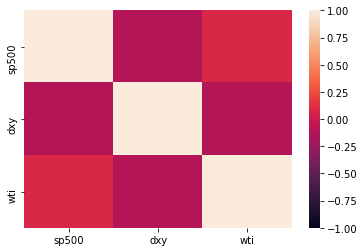

In [7]:
#Heat mapof correlations
sns.heatmap(oil_usd_sp500_corr, vmin=-1, vmax=1)

<AxesSubplot:>

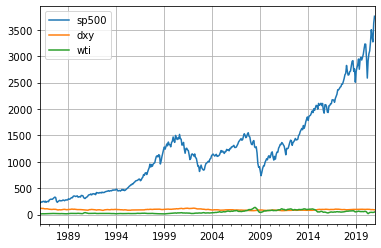

In [8]:
##Graph of monthly closing prices
oil_usd_sp500.plot(y=['sp500', 'dxy', 'wti'],grid=True)

<AxesSubplot:title={'center':'Monthly Closing Price'}, xlabel='year', ylabel='usd & wti'>

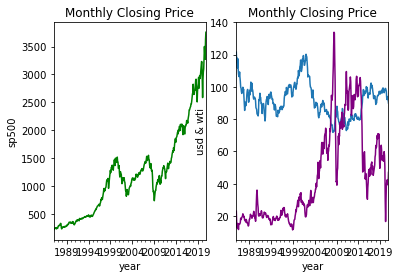

In [9]:
## Adding a second scale 
fig, ax = plt.subplots(1,2)

oil_usd_sp500['sp500'].plot(ax=ax[0], label= 'sp 500', color = 'green',xlabel='year', ylabel='sp500',title='Monthly Closing Price')
oil_usd_sp500['dxy'].plot(ax=ax[1], label= 'usd', xlabel='year', ylabel='usd & wti',title='Monthly Closing Price')
oil_usd_sp500['wti'].plot(ax=ax[1], label= 'wti', color= 'purple')

In [10]:
## 1-year rolling correlation
rolling_corr = oil_usd_sp500_return.rolling(window=12).corr().dropna()
rolling_corr.reset_index(inplace=True)
rolling_corr.rename(columns={"level_0":"Date"},inplace=True)
rolling_corr.set_index("Date",inplace=True)
rolling_corr.head()

,level_1,sp500,dxy,wti
Date,,,,
2019-12-01,sp500,1.000000,-0.615386,0.270033
2019-12-01,dxy,-0.615386,1.000000,-0.391844
2019-12-01,wti,0.270033,-0.391844,1.000000
2019-11-01,sp500,1.000000,-0.611275,0.262710
2019-11-01,dxy,-0.611275,1.000000,-0.376154


In [11]:
oil_price = oil_usd_sp500[['sp500','wti']].hvplot.line(xlabel="Date", ylabel="Monthly Closing Price")
usd_price = oil_usd_sp500[['sp500','dxy']].hvplot.line(xlabel="Date", ylabel="Monthly Closing Price")
all_price = oil_usd_sp500[['sp500','wti', 'dxy']].hvplot.line(xlabel="Date", ylabel="Monthly Closing Price")

In [12]:
sp500_corr = rolling_corr[rolling_corr['level_1'] == 'sp500'].sp500
dxy_oil_corr = rolling_corr[rolling_corr['level_1'] == 'dxy'].sp500
wti_corr = rolling_corr[rolling_corr['level_1'] == 'wti'].sp500

In [13]:
##
def oil_usd_sp500_correlation():
    oil_usd_sp500_correlation = oil_usd_sp500_corr.hvplot.heatmap(title = "USD, Oil and S&P500 Correlation")    
    return oil_usd_sp500_correlation

list_of_stock = ['dxy','wti']
def stock_price(stock):
    stock_price = oil_usd_sp500[["sp500",stock]].hvplot.line(title = f"Price of {stock} and S&P500",
                                                                           xlabel="Date",  ylabel="Monthly Close Price",ylim=(0,4000))
    return stock_price
def stock_correlation(stock):
    stock_corr = rolling_corr[rolling_corr['level_1'] == stock].sp500
    return stock_corr.hvplot.line(title = f"{stock} & S&P500 12 month Rolling Correlation", xlabel="Date", ylabel="Correlation")

In [14]:
##Setting up the output panel
stock_summary = pn.Column("#Stock and S&P500 Summary", all_price, oil_usd_sp500_correlation())

In [15]:
stock_analysis = pn.Column("#Stock Analysis", interact(stock_price, stock =list_of_stock), interact(stock_correlation, stock=list_of_stock))

In [16]:
panel1=pn.Tabs(
    ("stock Summary",stock_summary), ("stock Analysis",stock_analysis))

In [17]:
panel1.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] HoloViews(NdOverlay)
        [2] HoloViews(HeatMap)
    [1] Column
        [0] Markdown(str)
        [1] Column
            [0] Column
                [0] Select(name='stock', options=['dxy', 'wti'], value='dxy')
            [1] Row
                [0] HoloViews(NdOverlay, name='interactive01845')
        [2] Column
            [0] Column
                [0] Select(name='stock', options=['dxy', 'wti'], value='dxy')
            [1] Row
                [0] HoloViews(Curve, name='interactive01952')